# Programming Language Correlation

This sample notebook demonstrates working with GitHub activity made possible via the publicly accessible GitHub Timeline BigQuery dataset via the [GitHub Archive project](http://www.githubarchive.org/).

Here is the question that this notebook tackles, "_how likely are you to program in X, if you program in Y_." For example, this might be an input into an repository exploration/recommendation/search tool to personalize the results based on your own contributions.

It is based on an example published at http://datahackermd.com/2013/language-use-on-github/. It counts pushes or commits made by all users across all repositories on GitHub, and their associated repository languages, to determine the correlation between languages.

Related Links:

* [BigQuery](https://cloud.google.com/bigquery/what-is-bigquery)
* BigQuery [SQL reference](https://cloud.google.com/bigquery/query-reference)
* Python [Pandas](http://pandas.pydata.org/) for data analysis
* Python [matplotlib](http://matplotlib.org/) for data visualization

In [1]:
import gcp.bigquery as bq
import matplotlib.pyplot as plot
import numpy as np
import pandas as pd

# Understanding the GitHub Timeline

We're going to work with the GitHub Archive project data.  It contains all github events (commits, pushes, forks, watches, etc.) along with metadata about the events (e.g., user, time, place). The schema and sample data will help understand this dataset some more.

In [2]:
%%bigquery schema --table "githubarchive:github.timeline"

The GitHub timeline is a fairly large dataset. A quick lookup of table metadata gives us the row count.

In [3]:
table = bq.Table('githubarchive:github.timeline')
table.metadata.rows

290147550

With over 290 million events, it is important to be able to sample the data. The sample method allows you to sample tables, or queries.

In [4]:
table.sample(fields=['repository_name',
                     'repository_language',
                     'created_at',
                     'type'])

repository_name,repository_language,created_at,type
HexNanoController_Android,Java,2014-07-01 14:03:45,IssuesEvent
Learn-Downloader,Python,2014-07-01 14:03:44,PushEvent
angularjs-with-grunt-toolbox,,2014-07-01 14:03:44,CreateEvent
CmsBundle,PHP,2014-07-01 14:03:43,PushEvent
H2GIS,Java,2014-07-01 14:03:43,PushEvent


# Querying the Data

The first step in our analysis to correlate languages is going to be retrieving the appropriate slice of data.

We'll need to retrieve the list of PushEvents from the timeline. This is going to be a fairly large list of events, so there are a couple of ways to get a more manageable resultset:

* Limiting the analysis to the top 25 languages (from an otherwise really long list of languages which simply add noise).
* Limiting the analysis to just pushes made during 1 year time window; we will use 2014.
* Further sampling to get a small, but still interesting sample set to analyze further for correlation.

In [5]:
%%sql --module github

DEFINE QUERY popular_languages
SELECT repository_language AS language, COUNT(repository_language) as pushes
FROM [githubarchive:github.timeline]
WHERE type = 'PushEvent'
  AND repository_language != ''
  AND PARSE_UTC_USEC(created_at) >= TIMESTAMP("2014-01-01")
  AND PARSE_UTC_USEC(created_at) < TIMESTAMP("2015-01-01")
GROUP BY language
ORDER BY pushes DESC
LIMIT 25

DEFINE QUERY pushes
SELECT timeline.actor AS user,
       timeline.repository_language AS language,
       COUNT(timeline.repository_language) AS pushes
FROM [githubarchive:github.timeline] AS timeline
JOIN $popular_languages AS languages
  ON timeline.repository_language = languages.language
WHERE type = 'PushEvent'
  AND PARSE_UTC_USEC(created_at) >= TIMESTAMP("2014-01-01") 
  AND PARSE_UTC_USEC(created_at) < TIMESTAMP("2015-01-01") 
GROUP BY user, language

DEFINE QUERY pushes_sample
SELECT user, language, pushes
FROM $pushes
WHERE ABS(HASH(user)) % 100 < 5

## Checking out the Results

In [6]:
bq.Query(github.popular_languages).results()

language,pushes
JavaScript,11669779
Java,7737914
Python,6016436
CSS,5879794
PHP,4871379
Ruby,4345423
C++,3425502
C,2836812
Shell,1993268
C#,1734651


In [7]:
query = bq.Query(github.pushes_sample)
print query.sql

query.results()

SELECT user, language, pushes
FROM (SELECT timeline.actor AS user,
       timeline.repository_language AS language,
       COUNT(timeline.repository_language) AS pushes
FROM [githubarchive:github.timeline] AS timeline
JOIN (SELECT repository_language AS language, COUNT(repository_language) as pushes
FROM [githubarchive:github.timeline]
WHERE type = 'PushEvent'
  AND repository_language != ''
  AND PARSE_UTC_USEC(created_at) >= TIMESTAMP("2014-01-01")
  AND PARSE_UTC_USEC(created_at) < TIMESTAMP("2015-01-01")
GROUP BY language
ORDER BY pushes DESC
LIMIT 25) AS languages
  ON timeline.repository_language = languages.language
WHERE type = 'PushEvent'
  AND PARSE_UTC_USEC(created_at) >= TIMESTAMP("2014-01-01") 
  AND PARSE_UTC_USEC(created_at) < TIMESTAMP("2015-01-01") 
GROUP BY user, language)
WHERE ABS(HASH(user)) % 100 < 5


user,language,pushes
pituz,Shell,70
thedanyaal,C#,72
Bennell,Ruby,149
VlSePr,C++,1
jurialmunkey,Python,287
zachlatta,Shell,72
ajfigueroa,Ruby,12
naveensnayak,JavaScript,11
bdurkee,TeX,10
kyaukyuai,VimL,10


# Analyzing the Data

The next step is to integrate the BigQuery SQL queries with the analysis capabilities provided by python and pandas. The query defined earlier can be easily materialized into a pandas dataframe.

In [8]:
df = query.to_dataframe()

Great, so we've successfully populated a Pandas dataframe with our dataset. Let's dig into our dataset a little further using the dataframe to see if our data makes sense.

In [9]:
df[:10]

,user,language,pushes
0,pituz,Shell,70
1,thedanyaal,C#,72
2,Bennell,Ruby,149
3,VlSePr,C++,1
4,jurialmunkey,Python,287
5,zachlatta,Shell,72
6,ajfigueroa,Ruby,12
7,naveensnayak,JavaScript,11
8,bdurkee,TeX,10
9,kyaukyuai,VimL,10


In [10]:
summary = df['user'].describe()

print 'DataFrame contains %d with %d unique users' % (summary['count'], summary['unique'])

DataFrame contains 119848 with 67932 unique users


Let's see who is the most polyglot user of the mix.

In [11]:
print '%s has contributions in %d languages' % (summary['top'], summary['freq'])

df[df['user'] == summary['top']]

gregnietsky has contributions in 17 languages


,user,language,pushes
5509,gregnietsky,C#,68
8435,gregnietsky,Perl,104
30991,gregnietsky,Emacs Lisp,162
34735,gregnietsky,Go,8
37426,gregnietsky,R,1
38741,gregnietsky,Objective-C,29
50540,gregnietsky,JavaScript,38
57403,gregnietsky,PHP,102
68409,gregnietsky,Ruby,97
83439,gregnietsky,TeX,24


## Reshaping the Data

The results we have so far, have multiple rows for each user. Specifically, one per language. The next step is to pivot that data, so we have one row per user, and one column per language. The resulting matrix will be extremely sparse. We'll just fill in 0, as in no pushes, for user/language pairs that have no data.

Pandas offers a built-in `pivot()` method, which helps here.

In [12]:
dfp = df.pivot(index = 'user', columns = 'language', values = 'pushes').fillna(0)
dfp

language,C,C#,C++,CSS,Clojure,CoffeeScript,Emacs Lisp,Go,Groovy,Haskell,...,PHP,Perl,Puppet,Python,R,Ruby,Scala,Shell,TeX,VimL
user,,,,,,,,,,,,,,,,,,,,,
000014h,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,9,0,0,0,0,0,0
0065paula,0,0,0,13,0,0,0,0,0,0,...,0,0,0,23,0,0,0,0,0,0
008agent,5,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00Christina,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,6,0,0,0,0,0
00StevenG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
0110,136,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01Comandos,0,0,0,16,0,0,0,0,0,0,...,13,0,0,0,0,0,0,0,0,0


And then compute the correlation for each pair of languages, again, built-in into the pandas library.

In [13]:
corr = dfp.corr(method = 'spearman')
corr

language,C,C#,C++,CSS,Clojure,CoffeeScript,Emacs Lisp,Go,Groovy,Haskell,...,PHP,Perl,Puppet,Python,R,Ruby,Scala,Shell,TeX,VimL
language,,,,,,,,,,,,,,,,,,,,,
C,1.000000,-0.012667,0.215929,-0.028122,0.008086,0.014868,0.039291,0.042316,-0.002628,0.049547,...,-0.052189,0.059339,0.014270,0.076151,-0.040796,-0.011833,-0.003384,0.120042,0.069233,0.051881
C#,-0.012667,1.000000,0.008120,-0.048974,-0.006862,0.000899,-0.011923,-0.012562,-0.011499,-0.001235,...,-0.052348,-0.012320,-0.011715,-0.053210,-0.044318,-0.054772,-0.009414,-0.026561,-0.010320,-0.025698
C++,0.215929,0.008120,1.000000,-0.047919,0.000032,0.004515,0.033359,0.019747,-0.013814,0.029908,...,-0.062072,0.026385,-0.008928,0.064300,-0.042493,-0.044364,-0.003780,0.054788,0.062367,0.032380
CSS,-0.028122,-0.048974,-0.047919,1.000000,0.029216,0.086525,0.020531,0.037677,0.002577,0.008566,...,0.056731,0.015350,0.018909,0.021561,-0.053243,0.107598,0.003398,0.067056,0.013735,0.053611
Clojure,0.008086,-0.006862,0.000032,0.029216,1.000000,0.027719,0.135346,0.040716,0.015901,0.067814,...,-0.017805,0.018555,0.017142,0.025208,0.000196,0.046802,0.021253,0.050528,0.012176,0.056023
CoffeeScript,0.014868,0.000899,0.004515,0.086525,0.027719,1.000000,0.015222,0.066095,0.008583,0.031140,...,0.004220,0.006983,0.017650,0.041302,-0.017610,0.093937,0.010299,0.091305,0.006638,0.084480
Emacs Lisp,0.039291,-0.011923,0.033359,0.020531,0.135346,0.015222,1.000000,0.057795,-0.003439,0.091057,...,-0.011975,0.027450,0.006120,0.045582,-0.006442,0.030842,0.021144,0.096487,0.031734,0.047287
Go,0.042316,-0.012562,0.019747,0.037677,0.040716,0.066095,0.057795,1.000000,0.008795,0.035673,...,-0.003716,0.027789,0.036949,0.062464,-0.016176,0.066931,0.030380,0.104101,0.022824,0.084233
Groovy,-0.002628,-0.011499,-0.013814,0.002577,0.015901,0.008583,-0.003439,0.008795,1.000000,0.009896,...,-0.022254,0.003968,0.006685,-0.006597,-0.010881,0.000720,0.036075,0.040047,0.003764,0.001663


# Visualizing the Results

The correlation table above contains all the results, but isn't very telling. A plot will make the data speak a lot louder, and highlight the highly correlated languages, as well as highly uncorrelated languages.

In [14]:
# Plotting helper function
def plot_correlation(data):
  min_value = 0
  max_value = 0

  for i in range(len(data.columns)):
    for j in range(len(data.columns)):
      if i != j:
        min_value = min(min_value, data.iloc[i, j])
        max_value = max(max_value, data.iloc[i, j])
  span = max(abs(min_value), abs(max_value))
  span = round(span + .05, 1)

  items = data.columns.tolist()
  ticks = np.arange(0.5, len(items) + 0.5)

  plot.figure(figsize = (11, 7))
  plot.pcolor(data.values, cmap = 'RdBu', vmin = -span, vmax = span)
  plot.colorbar().set_label('correlation')
  plot.xticks(ticks, items, rotation = 'vertical')
  plot.yticks(ticks, items)
  plot.show()

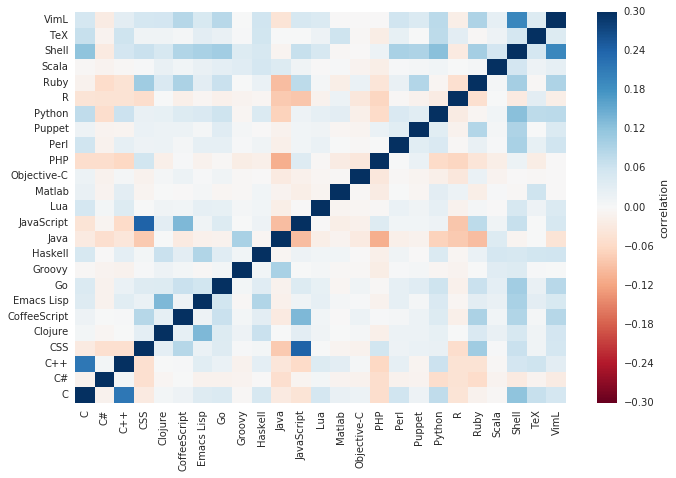

In [15]:
plot_correlation(corr)

# Takeaways and Observations

We can see that JavaScript and CSS pushes have strong positive correlation, as well as C and C++, and Objective-C and Swift (good sanity check).

* No surprise ... JavaScript is highly correlated with CSS, and C with C++. These are just good sanity checks.
* A bit surprising ... Java has some strong uncorrelations - with JavaScript, PHP and Ruby ... static vs. dynamic languages?
* Also surprising ... R seems not so correlated with Python?
* Go is not uncorrelated with anything other than Java, even if not highly correlated. Go programmers do not exclusively program in Go.
* And PHP is uncorrelated with many languages. Maybe a different developer persona altogether?